In [1]:
import sys
sys.path.append('../code/hnn_rc')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, hnn_rc_param_function, UniformPrior, linear_scale_array,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_hnn)
from hnn_core import jones_2009_model
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../data/hnn_rc'

with open(f'{data_path}/posteriors/hnn_rc_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/hnn_rc_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
zero_samples = posterior_metadata['zero_samples']

In [2]:
# Parameter bounds
for param_name, param_dict in prior_dict.items():
    print(f'{param_name}:{param_dict["bounds"]}', end=' ')

prox_weight:(-4, -3) dist_weight:(-4, -3) latency:(-75, 75) 

### Generate conditioning waveform

In [3]:
net = jones_2009_model()
net.clear_connectivity()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_rc_param_function,
                    network_model=net)

In [4]:
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond = np.array([0.3, 0.5, 0.7])

theta_dict = {param_name: param_dict['rescale_function'](theta_cond[idx], param_dict['bounds']) for 
              idx, (param_name, param_dict) in enumerate(prior_dict.items())}

x_cond = simulator(torch.tensor(theta_cond).float()).numpy()
x_cond[:, :zero_samples] = np.zeros(x_cond[:, :zero_samples].shape)

print(theta_dict)

{'prox_weight': 0.00019952623697367425, 'dist_weight': 0.00031622776601683794, 'latency': 29.999998211860657}
joblib will run over 1 jobs
Loading custom mechanism files from /home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/hnn_core/mod/x86_64/.libs/libnrnmech.so
Building the NEURON model
[Done]
running trial 1 on 1 cores
Simulation time: 0.5 ms...
Simulation time: 10.0 ms...
Simulation time: 20.0 ms...
Simulation time: 30.0 ms...
Simulation time: 40.0 ms...
Simulation time: 50.0 ms...
Simulation time: 60.0 ms...
Simulation time: 70.0 ms...
Simulation time: 80.0 ms...
Simulation time: 90.0 ms...
Simulation time: 100.0 ms...
Simulation time: 110.0 ms...
Simulation time: 120.0 ms...
Simulation time: 130.0 ms...
Simulation time: 140.0 ms...
Simulation time: 150.0 ms...
Simulation time: 160.0 ms...
Simulation time: 170.0 ms...
Simulation time: 180.0 ms...
Simulation time: 190.0 ms...
Simulation time: 200.0 ms...
Simulation time: 210.0 ms...
Simulation time: 220.0 ms...
Simulatio

/home/ntolley/Jones_Lab/hnn_sbi_examples/notebooks/../code/hnn_rc/utils.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=torch.float32)


Text(0, 0.5, 'Dipole (nAm)')

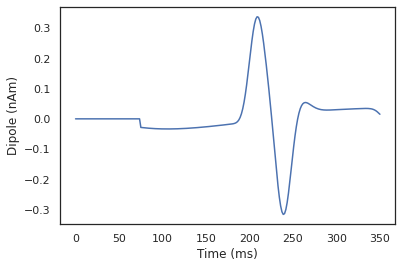

In [5]:
%matplotlib inline
t_vec = np.linspace(0, tstop, x_cond.shape[1])
plt.plot(t_vec, x_cond.squeeze())
plt.xlabel('Time (ms)')
plt.ylabel('Dipole (nAm)')

### Load trained posterior objects

In [6]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_orig_peak = get_dataset_peaks(x_orig)
x_cond_peak = get_dataset_peaks(x_cond.T)

fs = posterior_metadata['fs'] # Frequency defined for PSD
x_orig_psd, f = get_dataset_psd(x_orig, fs=fs)
x_cond_psd, f = get_dataset_psd(x_cond.T, fs=fs)

load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                    'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
             for name, posterior_dict in posterior_state_dicts.items()}

posterior_names = list(posterior_state_dicts.keys())
print(posterior_names)

['raw_waveform', 'pca5', 'pca10', 'pca30', 'peak', 'psd', 'psd_peak']


In [18]:
name_idx = 5 # Pick posterior to load

input_type = posterior_names[name_idx]
posterior_dict = posterior_state_dicts[input_type]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

posterior = load_posterior(state_dict=state_dict,
                           x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                           theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

### Draw samples and plot

Conditioning Feature: psd


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

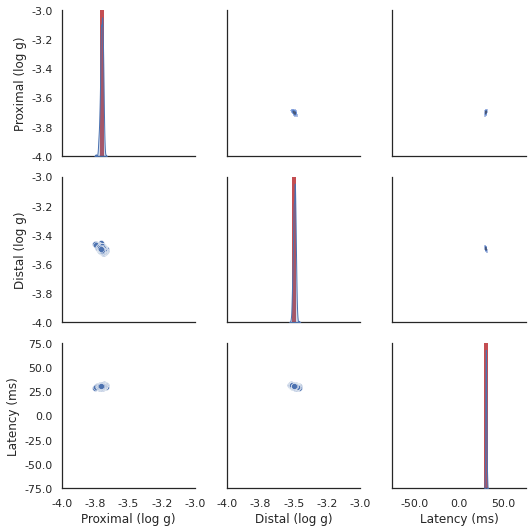

In [19]:
print(f'Conditioning Feature: {posterior_names[name_idx]}')
num_samples = 1000

all_labels = ['Proximal (log g)', 'Distal (log g)', 'Latency (ms)']
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]

df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}


df = pd.DataFrame(df_dict)

g = sns.PairGrid(df,  diag_sharey=False)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot, fill=True)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(3):
    g.axes[idx, idx].axvline(theta_cond_transformed[idx], color='r', linewidth=4) 
    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

for idx1 in range(3):
    for idx2 in range(3):
        g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()

In [17]:
load_info['peak']

{'x_train': array([[  0.85036665, 208.79828326,  -0.46664768,  28.54077253],
        [  1.65718925, 208.79828326,  -0.46664768,  28.54077253],
        [  0.21867216, 208.79828326,  -0.46664768,  28.54077253],
        ...,
        [  0.53594697, 208.79828326,  -0.46664768,  28.54077253],
        [  0.93463403, 208.79828326,  -0.46664768,  28.54077253],
        [  1.45641029, 208.79828326,  -0.46664768,  28.54077253]]),
 'x_cond': array([[  0.33714846, 208.79828326,  -0.31559211, 238.84120172]])}